In [1]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import shuffle
import helper
print("Done")

Done


## Load model

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"#"cuda:0"
else:
    device = "cpu"
    
url = 'https://raw.githubusercontent.com/salmanedhi/NNTI-WS2021-NLP-Project/main/data/hindi_hatespeech.tsv'

data = pd.read_csv(url, sep='\t')
    
#data = pd.read_csv('data/hindi_hatespeech.tsv', sep='\t')
data_development = shuffle(data)
labels = data_development['task_2']
# data_development = data
type(data_development['task_1'])

print("Done", device)

Done cuda:0


In [3]:
#Stopwords Removal
sentences = helper.apply_stopword_removal(data_development)
print("Number of sentences: " , len(sentences))

#Building Vocabulary
V, non_unique = helper.build_vocabulary(sentences)
print('Total words:', len(non_unique))
print('Unique words:', len(V))

Number of sentences:  4665
Total words: 141550
Unique words: 19836


In [4]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_finalised', device, len(V), 600)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=19836, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=19836, bias=True)
)
torch.Size([19837, 600]) torch.Size([600, 19836])


## Create Dataset

In [5]:
## create number array of sentences (replace each word with each numeric value)
x_data, max_len_curr = helper.sentence_to_numeric_arr(sentences, V)

## apply padding
padded = np.array(helper.padding(x_data, max_len_curr))

print(padded.shape)
encoded_labels = [0 if label == "NONE" else 1 for label in labels]
encoded_labels = np.array(encoded_labels)
print(encoded_labels.shape)

(4665, 132)
(4665,)


In [6]:
#split data into train, valid & test set

print(type(padded), type(encoded_labels))
batch_size = 64
train_loader, valid_loader, test_loader = helper.split_data_train_valid_test(padded, encoded_labels, batch_size)
print("Done")

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Done


In [7]:
net, criterion= helper.initialize_SentimentLSTM_model(len(V) + 1, 600, 32, 1, 2, device, weights1)

print(net)

SentimentLSTM(
  (embedding): Embedding(19837, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 200  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
#         print(i, inputs.shape, labels.shape)
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if (step % print_every) == 0:            
            ######################
            ##### VALIDATION #####
            ######################
            net.eval()
            valid_losses = []
            v_h = net.init_hidden(batch_size, device)
            
            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = inputs.to(device), labels.to(device)
        
                v_h = tuple([each.data for each in v_h])
                
                v_output, v_h = net(v_inputs, batch_size)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())

            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
    
print("Done")

<ipython-input-8-615d560f5db7>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/200 Training Loss: 0.6911
Epoch: 2/200 Step: 100 Training Loss: 0.6563 Validation Loss: 0.6563
Epoch: 2/200 Training Loss: 0.6775
Epoch: 3/200 Training Loss: 0.6708
Epoch: 4/200 Step: 200 Training Loss: 0.6521 Validation Loss: 0.6470
Epoch: 4/200 Training Loss: 0.6696
Epoch: 5/200 Training Loss: 0.6630
Epoch: 6/200 Step: 300 Training Loss: 0.6577 Validation Loss: 0.6626
Epoch: 6/200 Training Loss: 0.6587
Epoch: 7/200 Step: 400 Training Loss: 0.6461 Validation Loss: 0.6421
Epoch: 7/200 Training Loss: 0.6600
Epoch: 8/200 Training Loss: 0.7428
Epoch: 9/200 Step: 500 Training Loss: 0.6911 Validation Loss: 0.6923
Epoch: 9/200 Training Loss: 0.6933
Epoch: 10/200 Training Loss: 0.6927
Epoch: 11/200 Step: 600 Training Loss: 0.6951 Validation Loss: 0.6981
Epoch: 11/200 Training Loss: 0.6929
Epoch: 12/200 Training Loss: 0.6914
Epoch: 13/200 Step: 700 Training Loss: 0.6917 Validation Loss: 0.6909
Epoch: 13/200 Training Loss: 0.6913
Epoch: 14/200 Step: 800 Training Loss: 0.6830 Validation

### Printing weights

In [9]:
for param in net.parameters():
  print(param.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.6557e-03,  7.0117e-03, -2.8231e-03,  ...,  7.2872e-03,
          3.9233e-04, -3.9099e-03],
        [ 2.3458e-03, -3.2887e-03, -3.0864e-03,  ...,  5.5859e-03,
          7.9610e-03, -1.1799e-04],
        ...,
        [-1.5140e-03, -3.0222e-03, -5.4241e-03,  ...,  1.3369e-03,
         -5.6326e-04,  7.2260e-03],
        [-1.2677e-03, -3.2872e-03, -2.2281e-03,  ...,  3.7003e-03,
         -3.3115e-03, -3.5441e-03],
        [ 3.2113e-03,  1.9682e-05,  1.4377e-03,  ..., -2.3011e-03,
         -3.5223e-03, -1.9228e-03]], device='cuda:0')
tensor([[ 0.2149, -0.0815, -0.2503,  ...,  0.1681, -0.2624,  0.5247],
        [ 0.0918, -0.3138, -0.0530,  ...,  0.4256, -0.3333, -0.0532],
        [-0.0268, -0.2088,  0.2165,  ..., -0.1199, -0.1667,  0.0583],
        ...,
        [-0.1521, -0.4117,  0.0564,  ...,  0.0353,  0.1782,  0.0133],
        [ 0.4272, -0.3766, -0.1141,  ...,  0.1791, -0.1743

200


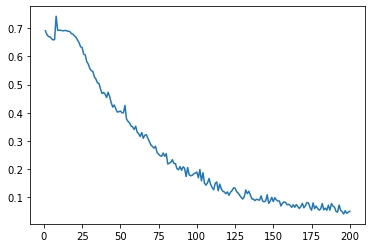

In [10]:
print(len(training_loss_epoches))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
torch.save(net, 'model_task2_finalised')
torch.save(net.state_dict(), 'model_param_task2_finalised')

In [16]:
# net.load_state_dict(torch.load('model_param_task2')) #GPU
net = torch.load('model_task2_finalised')
# net.load_state_dict(torch.load('model_param_task2_final',map_location=torch.device('cpu'))) #for salman CPU only
net.to(device)

SentimentLSTM(
  (embedding): Embedding(19837, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
for param in net.parameters():
  print(param.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.6557e-03,  7.0117e-03, -2.8231e-03,  ...,  7.2872e-03,
          3.9233e-04, -3.9099e-03],
        [ 2.3458e-03, -3.2887e-03, -3.0864e-03,  ...,  5.5859e-03,
          7.9610e-03, -1.1799e-04],
        ...,
        [-1.5140e-03, -3.0222e-03, -5.4241e-03,  ...,  1.3369e-03,
         -5.6326e-04,  7.2260e-03],
        [-1.2677e-03, -3.2872e-03, -2.2281e-03,  ...,  3.7003e-03,
         -3.3115e-03, -3.5441e-03],
        [ 3.2113e-03,  1.9682e-05,  1.4377e-03,  ..., -2.3011e-03,
         -3.5223e-03, -1.9228e-03]], device='cuda:0')
tensor([[ 0.2521, -0.4896,  0.1144,  ...,  0.3995, -0.1455,  0.7618],
        [ 0.4981, -0.2003,  0.1955,  ...,  0.1075, -0.0539,  1.2503],
        [-0.1223, -0.1559, -0.1464,  ...,  0.2404, -0.0912,  0.3481],
        ...,
        [ 0.2038,  0.2649, -0.1377,  ...,  0.0828,  0.0068,  0.3901],
        [ 0.2663, -0.0365, -0.2142,  ..., -0.2389,  0.1267

## Test set

In [14]:

net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.8122
Test Accuracy: 0.64


In [11]:
print(len(test_y) - np.sum(test_y))
print(np.sum(test_y))
print(len(encoded_labels))
print(np.sum(encoded_labels))

NameError: name 'test_y' is not defined

## Testing Bengali Data on Hindi Classifier

In [15]:
#Reading Bengali data
bengali_data, labels = helper.get_bengali_data('data/bengali_hatespeech.csv')
# print(bengali_data)
print(bengali_data.shape, labels.shape)

(4665, 3) (4665,)


In [16]:
## Stopwords Removal of Bengali Data
bengali_sentences = helper.apply_stopword_removal(bengali_data)
print("Number of sentences: " , len(bengali_sentences))

## Building Vocabulary
bengali_V, bengali_non_unique = helper.build_vocabulary(bengali_sentences)
print('Total words:', len(bengali_non_unique))
print('Unique words:', len(bengali_V))

## Sentence to numeric array
x_data_bengali, max_len_curr = helper.sentence_to_numeric_arr(bengali_sentences, bengali_V)

## Apply Padding
padded = np.array(helper.padding(x_data_bengali, max_len_curr))
print(padded.shape)

Number of sentences:  4665
Total words: 64027
Unique words: 14482
(4665, 402)


In [17]:
#create test data to pass to the model
test_data = TensorDataset(torch.tensor(padded), torch.tensor(labels))
batch_size = 64
train_loader, valid_loader, test_loader = helper.split_data_train_valid_test(padded, labels, 64)
net, criterion= helper.initialize_SentimentLSTM_model_bengali(len(V) + 1, 600, 32, 1, 2, device, weights1)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Transfer Learning

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 200  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
#         print(i, inputs.shape, labels.shape)
        # making requires_grad = False for the latest set of h
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if (step % print_every) == 0:            
            ######################
            ##### VALIDATION #####
            ######################
            net.eval()
            valid_losses = []
            v_h = net.init_hidden(batch_size, device)
            
            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = inputs.to(device), labels.to(device)
        
                v_h = tuple([each.data for each in v_h])
                
                v_output, v_h = net(v_inputs, batch_size)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())

            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
    
print("Done")

<ipython-input-18-615d560f5db7>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/200 Training Loss: 0.6683
Epoch: 2/200 Step: 100 Training Loss: 0.3855 Validation Loss: 0.3404
Epoch: 2/200 Training Loss: 0.3418
Epoch: 3/200 Training Loss: 0.1449
Epoch: 4/200 Step: 200 Training Loss: 0.0378 Validation Loss: 0.0274
Epoch: 4/200 Training Loss: 0.0714
Epoch: 5/200 Training Loss: 0.0482
Epoch: 6/200 Step: 300 Training Loss: 0.0376 Validation Loss: 0.0237
Epoch: 6/200 Training Loss: 0.0393
Epoch: 7/200 Step: 400 Training Loss: 0.0718 Validation Loss: 0.0350
Epoch: 7/200 Training Loss: 0.0216
Epoch: 8/200 Training Loss: 0.0178
Epoch: 9/200 Step: 500 Training Loss: 0.0285 Validation Loss: 0.0131
Epoch: 9/200 Training Loss: 0.0165
Epoch: 10/200 Training Loss: 0.0117
Epoch: 11/200 Step: 600 Training Loss: 0.0026 Validation Loss: 0.0012
Epoch: 11/200 Training Loss: 0.0097
Epoch: 12/200 Training Loss: 0.0104
Epoch: 13/200 Step: 700 Training Loss: 0.0038 Validation Loss: 0.0033
Epoch: 13/200 Training Loss: 0.0081
Epoch: 14/200 Step: 800 Training Loss: 0.0012 Validation

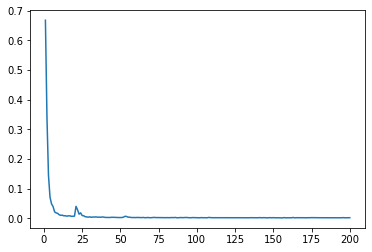

In [19]:

# net, criterion= helper.initialize_SentimentLSTM_model(len(V) + 1, 600, 32, 1, 2, device, weights1)
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)

# net.load_state_dict(torch.load('model_param_task2_test')) #GPU

# net.load_state_dict(torch.load('model_param_task2_final',map_location=torch.device('cpu'))) #for salman CPU only
# net.to(device)

In [20]:
net.eval()

test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 2.0306
Test Accuracy: 0.75


## Training classifier on Bengali embeddings

In [21]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_finalised_bengali', device, len(bengali_V), 600)
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=14482, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=14482, bias=True)
)
torch.Size([14483, 600]) torch.Size([600, 14482])


In [22]:
#split data into train, valid & test set
# labels = labels.cpu().detach().numpy()
print(padded.shape, labels.shape)
print(type(padded), type(labels))

print("Done")

(4665, 402) torch.Size([64])
<class 'numpy.ndarray'> <class 'torch.Tensor'>
Done


In [23]:
net, criterion = helper.initialize_SentimentLSTM_model(len(bengali_V) + 1, 600, 32, 1, 2, device, weights1)

print(net)

SentimentLSTM(
  (embedding): Embedding(14483, 600)
  (lstm): LSTM(600, 32, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [24]:
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, amsgrad=True)
print_every = 100
step = 0
n_epochs = 100  # validation loss increases from ~ epoch 3 or 4
clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# if torch.cuda.is_available():
#     device = "cuda:0"
# else:
#     device = "cpu"
# print(device)

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if (step % print_every) == 0:            
            ######################
            ##### VALIDATION #####
            ######################
            net.eval()
            valid_losses = []
            v_h = net.init_hidden(batch_size, device)
            
            for v_inputs, v_labels in valid_loader:
                v_inputs, v_labels = inputs.to(device), labels.to(device)
        
                v_h = tuple([each.data for each in v_h])
                
                v_output, v_h = net(v_inputs, batch_size)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())

            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(np.mean(valid_losses)))
            net.train()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
    
print("Done")

<ipython-input-24-4a2a9920d6d9>:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/100 Training Loss: 0.6926
Epoch: 2/100 Step: 100 Training Loss: 0.6556 Validation Loss: 0.6580
Epoch: 2/100 Training Loss: 0.6688
Epoch: 3/100 Training Loss: 0.5723
Epoch: 4/100 Step: 200 Training Loss: 0.4564 Validation Loss: 0.4169
Epoch: 4/100 Training Loss: 0.4927
Epoch: 5/100 Training Loss: 0.4381
Epoch: 6/100 Step: 300 Training Loss: 0.5123 Validation Loss: 0.4533
Epoch: 6/100 Training Loss: 0.3970
Epoch: 7/100 Step: 400 Training Loss: 0.4728 Validation Loss: 0.4199
Epoch: 7/100 Training Loss: 0.3559
Epoch: 8/100 Training Loss: 0.3093
Epoch: 9/100 Step: 500 Training Loss: 0.4244 Validation Loss: 0.3558
Epoch: 9/100 Training Loss: 0.2688
Epoch: 10/100 Training Loss: 0.2294
Epoch: 11/100 Step: 600 Training Loss: 0.2364 Validation Loss: 0.1606
Epoch: 11/100 Training Loss: 0.2078
Epoch: 12/100 Training Loss: 0.1795
Epoch: 13/100 Step: 700 Training Loss: 0.1443 Validation Loss: 0.1387
Epoch: 13/100 Training Loss: 0.1614
Epoch: 14/100 Step: 800 Training Loss: 0.0869 Validation

100


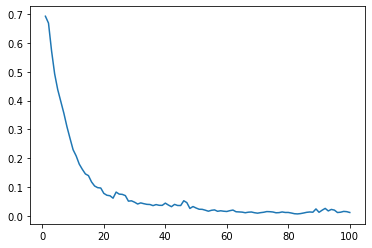

In [25]:
print(len(training_loss_epoches))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
torch.save(net, 'model_bengali_task2')
torch.save(net.state_dict(), 'model_param_bengali_task2')

In [26]:
# import os 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    
    
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.6829
Test Accuracy: 0.72
